In [1]:
# https://arxiv.org/abs/1610.02415

# https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
print("Code is running!")
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn

from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A
import edge_removing as A_alternate
from torch_geometric.nn import GCNConv

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from rdkit.Chem import PeriodicTable
from rdkit import Chem
from xenonpy.datatools import preset
from xenonpy.descriptor import Compositions
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from matplotlib.pylab import plt
from numpy import arange
import math
import timeit
import os
from datetime import datetime

Code is running!


In [2]:
#record start time
t_0 = timeit.default_timer()
# call function

In [57]:
dataset = "QM9"
tr_batch_size = 1000
val_batch_size = 200
test_batch_size = 100
tr_ratio = 0.9
val_ratio = 0.09
test_ratio = 0.01
num_workers = 2
shuffle = True
qm9_index_list = ['Dipole_moment', 
                  'Isotropic_polarizability',
                  'Highest_occupied_molecular_orbital_energy',
                  'Lowest_unoccupied_molecular_orbital_energy',
                  'Gap_between_previous_2',
                  'Electronic_spatial_extent',
                  'Zero_point_vibrational_energy',
                  'Internal_energy_at_0K',
                  'Internal_energy_at_298.15K',
                  'Enthalpy_at_298.15K',
                  'Free_energy_at_298.15K',
                  'Heat_capacity_at_298.15K',
                  'Atomization_energy_at_0K',
                  'Atomization_energy_at_298.15K',
                  'Atomization_enthalpy_at_298.15K',
                  'Atomization_free_energy_at_298.15K',
                  'Rotational_constant_A',
                  'Rotational_constant_B',
                  'Rotational_constant_C']

parameters = {}
parameters['tr_batch_size'] = tr_batch_size

parameters_used = {}
parameters_used['dataset'] = dataset
parameters_used['tr_batch_size'] = tr_batch_size
parameters_used['val_batch_size'] = val_batch_size
parameters_used['test_batch_size'] = test_batch_size
parameters_used['tr_ratio'] = tr_ratio
parameters_used['val_ratio'] = val_ratio
parameters_used['test_ratio'] = test_ratio
parameters_used['num_workers'] = num_workers
parameters_used['shuffle'] = shuffle
parameters_used['target_properties'] = qm9_index_list

periodic_table = Chem.GetPeriodicTable()

In [58]:
whole_dataset = QM9(root = 'data/')

#print(whole_dataset.get_summary())
#print(dir(whole_dataset))
#print(whole_dataset.len())



n = whole_dataset.len()
tr_n = math.floor(tr_ratio*n) # Number of QM9 to use as training data
val_n = math.floor(val_ratio*n)



all_inds = range(n)
#print("all_inds: ", all_inds)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
val_test_inds = range(n - tr_n)
#print("val_test_inds: ", val_test_inds)
val_inds, test_inds = train_test_split(val_test_inds, train_size = val_n)


print("Size of training set: ", len(tr_inds))
print("Size of validation set: ", len(val_inds))
print("Size of test set: ", len(test_inds))
#print(type(tr_inds), type(tr_inds[0]))


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)
test_sampler = torch.utils.data.SubsetRandomSampler(test_inds)


# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)
test_set = torch.utils.data.Subset(whole_dataset, test_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = tr_batch_size,
                                                shuffle = shuffle, num_workers = num_workers)
                                                #sampler = train_sampler)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=val_batch_size,
                                            shuffle=shuffle, num_workers=num_workers, drop_last=True)
                                              #sampler = val_sampler)
test_loader = torch_geometric.loader.DataLoader(test_set, batch_size=test_batch_size,
                                            shuffle=shuffle, num_workers=num_workers)
                                              #sampler = val_sampler)

Size of training set:  117747
Size of validation set:  11774
Size of test set:  1310


In [5]:
test_graph_chem_formulae_dictionaries = pd.DataFrame()
tr_mol_list = []

In [6]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capacity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C'}



In [7]:
x_index = {0: 'H atom?',
1: 'C atom?',
2: 'N atom?',
3: 'O atom?',
4: 'F atom?',
5: 'atomic_number',
6: 'aromatic',
7: 'sp1',
8: 'sp2',
9: 'sp3',
10: 'num_hs'}
x_index_list = ['H atom?', 
                'C atom?', 
                'N atom?', 
                'O atom?', 
                'F atom?', 
                'atomic_number', 'aromatic', 
                'sp1',
                'sp2',
                'sp3',
                'num_hs']

In [8]:
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (tr_batch_size - 1)
    cov_y = (y.T @ y) / (tr_batch_size - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def atoms_dictionary(atomic_num):
    #print("atomic_num: ", atomic_num)
    atomic_symbol = periodic_table.GetElementSymbol(atomic_num)
    return atomic_symbol



In [9]:
def XenonPy_transform(df, df_dict_column):
    cal = Compositions()
    comps = df[df_dict_column]
    descriptors = cal.transform(comps)
    column_names = list(descriptors.columns)
    scaler = preprocessing.StandardScaler().fit(descriptors)
    descriptors = scaler.transform(descriptors)
    descriptors = pd.DataFrame(descriptors, columns = column_names)
    descriptors.rename(lambda x: str(x), axis='columns')
    descriptors.columns = descriptors.columns.astype(str)
    return(descriptors)

In [10]:
def get_mol_dict(batch):
    
    graph_chem_formulae_dictionaries = pd.DataFrame()
    if not graph_chem_formulae_dictionaries.empty:
        graph_chem_formulae_dictionaries.drop(columns = 'formula')

    node_to_graph_indicator = pd.DataFrame(batch.batch).astype("int")
    node = pd.DataFrame(batch.x).astype("int")
    mol_list = []
    j = 0
    mol_dict = {}
    for i in range(len(batch.z)):
            #get a dictionary for each graph that contains chemical formula
                #format for use for XenonPy
        if j == int(node_to_graph_indicator.iloc[i]):
                #add this ith atom to to the dictionary for the jth graph
                #atoms_dictionary(atomic_num)
                #call function to add element to molecular dictionary
            element = atoms_dictionary(int(node[5].iloc[i]))
            if element in mol_dict:
                mol_dict[element] = mol_dict[element] + 1
            else:
                mol_dict[element] = 1
        else: #need to move to next graph
                #Insert these dictionaries to each row in the df
            mol_list.append(mol_dict)
            mol_dict = {}
            element = atoms_dictionary(int(node[5].iloc[i]))
            j += 1

    mol_list.append(mol_dict) #need to append the last dict
    graph_chem_formulae_dictionaries.insert(0, 'formula', mol_list)
    for i in range(len(batch.y) - 1):
        if mol_list[i]:
            pass
        else:
            print("Empty!!", " location: ", i)

    return graph_chem_formulae_dictionaries

In [11]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        self.mpool2 = gnn.global_mean_pool
        self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
            #might want to get rid of this
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        # Input graph to GConv
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        # GConv outputs projected to representation space
        #print('before pool: ', x.shape)
        x_rep = self.mpool1(x, binds)
        #print('pooled: ', x_rep.shape)
        
        #x_rep = self.fc1(x_rep)
        #print('projected: ', x_rep.shape, 'gconv', x.shape)
        
        x_emb = self.bn3(self.conv3(x, edge_index))
        #print('x emb after conv3', x_emb.shape)
        x_emb = self.mpool2(x_emb, binds)
        #print('after pool', x_emb.shape)
        x_emb = self.fc2(x_emb)
        #print('after fc2', x_emb.shape)
        
        return x_rep, x_emb

In [35]:
device = 'cuda'

model = GCN().to(device)

sim_coeff = 25
std_coeff = 25
cov_coeff = 1
tr_augmentations = [#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A_alternate.EdgeRemoving(pe=0.1)]
val_augmentations = []
test_augmentations = []
tr_num_choices = 1
val_num_choices = 0
test_num_choices = 0

optimizer = 'Adam'
Adam_learning_rate = 0.002
Adam_weight_decay = 5e-4

parameters_used['sim_coeff'] = sim_coeff
parameters_used['std_coeff'] = std_coeff
parameters_used['cov_coeff'] = cov_coeff
parameters_used['tr_augmentations'] = tr_augmentations
parameters_used['val_augmentations'] = val_augmentations
parameters_used['test_augmentations'] = test_augmentations
parameters_used['tr_num_choices'] = tr_num_choices
parameters_used['val_num_choices'] = val_num_choices
parameters_used['test_num_choices'] = test_num_choices
parameters_used['optimizer'] = optimizer
parameters_used['Adam_learning_rate'] = Adam_learning_rate
parameters_used['Adam_weight_decay'] = Adam_weight_decay


tr_aug = A.RandomChoice(tr_augmentations, #edge_adj was deprecated, so need to use edge_ something instead
                      num_choices=tr_num_choices)
#should do many other types of augmentations
    #train models on all but one augmentations and see which work best
        #ablation study!
val_aug = A.RandomChoice(val_augmentations, num_choices = val_num_choices)
test_aug = A.RandomChoice(test_augmentations, num_choices = test_num_choices)
optimizer = torch.optim.Adam(model.parameters(), lr=Adam_learning_rate, weight_decay=Adam_weight_decay)


In [36]:
#for atom in mol.GetAtoms():
                #type_idx.append(types[atom.GetSymbol()])
#pseudocode to get molecule's chemical formula/SMILES/etc.

In [37]:
def plot_loss_curves(loss_per_epoch, val_loss):
    train_values = loss_per_epoch
    val_values = val_loss
 
    # Generate a sequence of integers to represent the epoch numbers
    epochs = range(0, len(loss_per_epoch))
 
    # Plot and label the training and validation loss values
    plt.plot(epochs, train_values, label='Training Loss')
    plt.plot(epochs, val_values, label='Validation Loss')
 
    # Add in a title and axes labels
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
 
    # Set the tick locations

    plt.xticks(arange(0, len(loss_per_epoch), max(math.floor(len(loss_per_epoch)/10), 1)))
 
    # Display the plot
    plt.legend(loc='best')
    plt.show()

In [38]:
tr_graph_chem_formulae_dictionaries = pd.DataFrame()
n_epochs = 1
epoch_loss = []
val_epoch_loss = []
print("Start training!")
for epoch in range(0,n_epochs+1):
    #print("epoch: ", epoch)
    epoch_losses = []
    for batch in train_loader:
        optimizer.zero_grad()

        batch_inds = batch.batch.to(device)
      
        # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)

        batch.x = batch.x.float()#.to(device)
        #batch.edge_index = batch.edge_index.to(device)

        # Barlow - get 2 random views of batch
        b1 = tr_aug(batch.x, batch.edge_index, batch.edge_attr)
        b2 = tr_aug(batch.x, batch.edge_index, batch.edge_attr)

        # Embed each batch (ignoring representations)
        r1, e1 = model(b1, batch_inds)
        r2, e2 = model(b2, batch_inds)

        loss = VicRegLoss(e1, e2)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.data.item())
        
    epoch_loss.append(sum(epoch_losses) / len(epoch_losses))
    print('epoch', epoch,'train loss:', sum(epoch_losses) / len(epoch_losses))

    
    val_loss = 0
    model.eval()
    
    # VicReg Validation Loss
    val_epoch_losses = []
    for batch in val_loader:
        with torch.no_grad():
            # VicReg validation loss
            b1 = val_aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = val_aug(batch.x, batch.edge_index, batch.edge_attr)
            r1, e1 = model(b1, batch.batch.to(device))
            r2, e2 = model(b2, batch.batch.to(device))
                
            val_loss = VicRegLoss(e1, e2)
            val_epoch_losses.append(val_loss.data.item())
            

    val_epoch_loss.append(sum(val_epoch_losses) / len(val_epoch_losses))    
    print('epoch', epoch,'val loss:', sum(val_epoch_losses) / len(val_epoch_losses))

    
print("Done augmenting!")        
               

Start training!
epoch 0 train loss: 19.7919727584063
epoch 0 val loss: 26.149098856695765
epoch 1 train loss: 24.241871462029927
epoch 1 val loss: 19.084297607684956
Done augmenting!


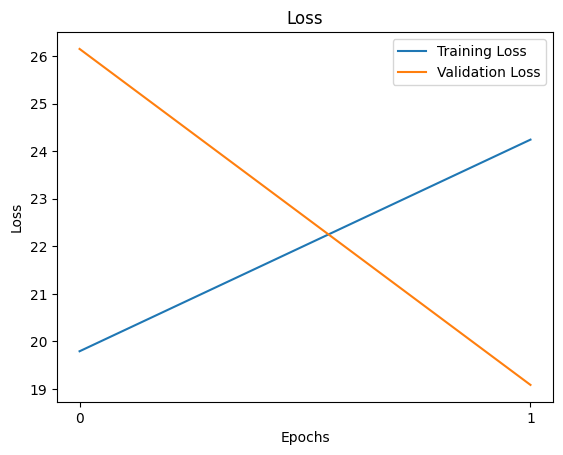

In [40]:
#plot train-val loss curves
plot_loss_curves(epoch_loss, val_epoch_loss)

In [39]:
#function to embed data
def get_embeddings(data_loader, model, aug):
    x = pd.DataFrame()
    x_no_aug = pd.DataFrame()
    y = pd.DataFrame()
    y_no_aug = pd.DataFrame()
    graph_chem_formulae_dictionaries = pd.DataFrame()
    for batch in data_loader: # take entire train set
        x_tabular_no_aug = pd.DataFrame(batch.x).astype("float")
        x_no_aug = pd.concat([x_no_aug, x_tabular_no_aug], ignore_index = True)
        y_tabular_no_aug = pd.DataFrame(batch.y).astype("float")
        y_no_aug = pd.concat([y_no_aug, y_tabular_no_aug], ignore_index = True)
        graph_chem_formulae_dictionaries = pd.concat([graph_chem_formulae_dictionaries, get_mol_dict(batch)], ignore_index = True)
        with torch.no_grad():
            # Embed training set under model
            rep, _ = model(aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))
            if torch.cuda.is_available():
                rep = rep.to("cpu")
            rep_tabular = pd.DataFrame(rep.numpy())
            x = pd.concat([x, rep_tabular], ignore_index = True)
            y_tabular = pd.DataFrame(batch.y).astype("float")
            y = pd.concat([y, y_tabular], ignore_index = True)
    
    return x, y, graph_chem_formulae_dictionaries, model

In [41]:
#get embeddings for training set
x_tr, y_tr, tr_graph_chem_formulae_dictionaries, model = get_embeddings(train_loader, model, tr_aug)


In [45]:
#get embeddings for validation set
x_val, y_val, val_graph_chem_formulae_dictionaries, model = get_embeddings(val_loader, model, val_aug)


In [46]:
#get embeddings for test set
x_test, y_test, test_graph_chem_formulae_dictionaries, model = get_embeddings(test_loader, model, test_aug)


In [18]:
#Get XenonPy transformation for training set
print("XenonPy transformation for training set:")
tr_df_XenonPy = XenonPy_transform(tr_graph_chem_formulae_dictionaries, 'formula')
print("Done with XenonPy transformation!")

XenonPy transformation for training set:


In [19]:
#Get XenonPy transformation for validation set
print("XenonPy transformation for val set:")
val_df_XenonPy = XenonPy_transform(val_graph_chem_formulae_dictionaries, 'formula')
print("Done with XenonPy transformation!")

XenonPy transformation for test set:
Done with XenonPy transformation!


In [ ]:
##Get XenonPy transformation for test set
#print("XenonPy transformation for test set:")
#val_df_XenonPy = XenonPy_transform(test_graph_chem_formulae_dictionaries, 'formula')
#print("Done with XenonPy transformation!")

In [60]:
def lm_models(x_train, x_test, y_train, y_test, lm_parameters):
    the = -2
    return the

In [61]:
def rf_models(x_train, x_test, y_train, y_test, rf_parameters):
    the = -2
    return the

In [62]:
def lgbm_models(x_train, x_test, y_train, y_test, lgbm_parameters):
    the = -2
    return the

In [20]:
#a function to run linear models
def linear_models(x_train, x_test, y_train, y_test, list_target_features):
    # For each task in QM9
    results_list = [] #list of dictionaries, where each dictionary contains the results from that model for each feature
    lgb_results_dict = {}
    rf_results_dict = {}
    lm_results_dict = {}
    downstream_model_parameters = {}
    means_vector = y_train.mean(axis = 0)
    rep_means_vectors = means_vector.repeat(x_train.shape[0]) #create a vector where each entry is the mean
    for target_feature in range(y_test.shape[1]):

        # Fit a model on model representation of train set:
        #Need to drop missing values for linear models, since they do not allow these
        #lm = LinearRegression().fit(x_train.values, y_train[target_feature].values)
        #lm_yhat = lm.predict(x_test.values)
        #lm_score = mean_squared_error(y_test[target_feature].values, lm_yhat)
        #print("Linear Regression Model MSE for ", list_target_features[target_feature], ": ", lm_score)
        #lm_results_dict["LM_" + qm9_index_list[target_feature]] = lm_score
        
        
        #Fit Random Forest models here:
        #rf = RandomForestRegressor(n_estimators=10, max_depth=10 )
        #rf.fit(x_train, y_train[target_feature])
        #rf_yhat = rf.predict(x_test)
        #rf_score = mean_squared_error(y_test[target_feature], rf_yhat)
        #print("RF Model Mean-Squared-Error for ", list_target_features[target_feature], ": ", rf_score)
        #rf_results_dict["RF_" + qm9_index_list[target_feature]] = rf_score
        
        
        #Fit LightGBM models here (LightGBM is supposedly better than XGBoost):
        lgb_train = lgb.Dataset(x_train.values, y_train[target_feature].values, params={'verbose': -1})
        lgb_eval = lgb.Dataset(x_test.values, y_test[target_feature].values, reference=lgb_train, params={'verbose': -1})
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'l2', 'l1'},
            'num_leaves': 31,
            'learning_rate': 0.05,
            'force_col_wise': 'true',
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }
        
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=20,
                        valid_sets=lgb_eval,
                        callbacks=[lgb.early_stopping(stopping_rounds=5)])
        lgb_yhat = gbm.predict(x_test.values, num_iteration=gbm.best_iteration)
        lgb_score = mean_squared_error(y_test[target_feature].values, lgb_yhat)
        print("LightGBM Model MSE for ", list_target_features[target_feature], ": ", lgb_score)
        lgb_results_dict["Light_GBM_" + qm9_index_list[target_feature]] = lgb_score
        
        # Test the model on model representation of val set
        
        
        
        
        rep_means_vectors = means_vector[target_feature].repeat(x_test.shape[0])
        baseline = mean_squared_error(y_test[target_feature].values, rep_means_vectors)
        #baseline is a model that always outputs the mean of the training sample
        print("Baseline MSE for ", list_target_features[target_feature], ": ", baseline)
        
        
    #results_list.append(lm_results_dict) #append Linear Model results dictionary to results list    
    results_list.append(lgb_results_dict) #append Light GBM results dictionary to results list
    #results_list.append(rf_results_dict) #append Random Forest results dictionary to results list
    
    
    return results_list, downstream_model_parameters
        
        
        

In [21]:
#need to make sure that I am getting the correct graphs for y's

In [22]:
#join XenonPy transformations with x_tr and x_val
x_tr.join(tr_df_XenonPy)
x_val.join(val_df_XenonPy)

,0,1,2,3,4,5,6,7,8,9,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,0.305842,0.379074,-0.541814,0.449133,-0.430187,0.778208,0.545574,-0.028445,-0.705860,0.761869,...,-0.029374,-0.029374,-0.022525,-0.263490,-0.029299,-0.028565,-0.027558,-0.028931,-0.286599,-0.004078
1,0.293850,0.501529,-0.611318,0.299307,-0.670040,1.042875,0.403959,0.093996,-0.588931,0.557370,...,-0.029374,-0.029374,-0.022525,-0.282522,-0.029299,-0.028565,-0.027558,-0.028931,-0.286599,-0.004078
2,0.309987,0.396983,-0.596406,0.386741,-0.434712,0.919793,0.439947,0.040069,-0.674842,0.582347,...,-0.029374,-0.029374,-0.022525,-0.282522,-0.029299,-0.028565,-0.027558,-0.028931,-0.286599,-0.004078
3,0.271763,0.200401,-0.346898,0.561746,-0.312393,0.736983,0.461685,0.042484,-0.843480,0.726393,...,-0.029374,-0.029374,-0.022525,3.642395,-0.029299,-0.028565,-0.027558,-0.028931,3.605967,-0.004078
4,0.281784,0.392232,-0.526789,0.450065,-0.429324,0.937050,0.487958,-0.004021,-0.730263,0.647817,...,-0.029374,-0.029374,-0.022525,-0.282522,-0.029299,-0.028565,-0.027558,-0.028931,-0.286599,-0.004078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,0.320525,0.350614,-0.588670,0.426030,-0.257726,0.919775,0.470203,-0.008676,-0.755224,0.594844,...,-0.029374,-0.029374,-0.022525,-0.282522,-0.029299,-0.028565,-0.027558,-0.028931,-0.220803,-0.004078
11596,0.325741,0.535410,-0.720694,0.342521,-0.480554,0.979609,0.499378,-0.041424,-0.616267,0.630647,...,-0.029374,-0.029374,-0.022525,-0.282522,-0.029299,-0.028565,-0.027558,-0.028931,-0.286599,-0.004078
11597,0.332796,0.581281,-0.797303,0.315162,-0.426771,1.020766,0.469717,-0.081697,-0.606481,0.616940,...,-0.029374,-0.029374,-0.022525,-0.282522,-0.029299,-0.028565,-0.027558,-0.028931,-0.286599,-0.004078
11598,0.379737,0.691173,-0.973931,0.331394,-0.132460,1.068031,0.470915,-0.273919,-0.701221,0.549858,...,-0.029374,-0.029374,-0.022525,3.642395,-0.029299,-0.028565,-0.027558,-0.028931,3.605967,-0.004078


In [23]:
#x_tr = x_tr.drop(index=[83501, 56941])
#need to drop the two rows with extremely large Rotational Constant A

In [24]:
#y_tr = y_tr.drop(index=[83501, 56941])
#need to drop the two rows with extremely large Rotational Constant A
#need to also drop extreme values for y_val, y_test, x_tr, x_val, and x_test

In [25]:
def df_extreme_values(df):
    
    for column in range(df.shape[1]):
        sorted_index_array = np.argsort(df[column])
        sorted_array = df[column][sorted_index_array]
        n = 10

        # find n largest value
        max_rslt = sorted_array[-n : ]
        min_rslt = sorted_array[ : n]
        #print(rslt)
        # show the output
        print(qm9_index_list[column], "max values:\n", max_rslt)
        print(qm9_index_list[column], "min values:\n", min_rslt)

In [34]:
#df_extreme_values(y_tr)

In [33]:
#df_extreme_values(y_val)

In [32]:
#df_extreme_values(y_test)

In [31]:
#df_extreme_values(x_tr)

In [ ]:
#df_extreme_values(x_val) #need to do this before transformation

In [ ]:
#df_extreme_values(x_test)

In [ ]:
#x_tr = pd.concat([x_tr, x_val]) #tr and val combined for training set
#y_tr = pd.concat([y_tr, y_val]) #tr and val combined for test set

In [30]:
results_list, downstream_model_parameters = linear_models(x_tr, x_test, y_tr, y_test, qm9_index)

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 1.31866	valid_0's l1: 0.89244
LightGBM Model MSE for  Dipole moment :  1.318656473373072
Baseline MSE for  Dipole moment :  2.222889292715312
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 119.542	valid_0's l1: 8.95836
LightGBM Model MSE for  Isotropic polarizability :  119.5419336118462
Baseline MSE for  Isotropic polarizability :  165.11591782754945
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.31309	valid_0's l1: 0.42172
LightGBM Model MSE for  Highest occupied molecular orbital energy :  0.3130897540117028
Baseline MSE for  Highest occupied molecular orbital energy :  0.500252599236454
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	

In [ ]:
#linear_models(x_tr_no_aug, x_val_no_aug, y_tr_no_aug, y_val_no_aug, qm9_index)

In [53]:
# record end time
t_1 = timeit.default_timer()
 
# calculate elapsed time and print

In [54]:
print(results_list)

[{'Light_GBM_Dipole_moment': 1.318656473373072, 'Light_GBM_Isotropic_polarizability': 119.5419336118462, 'Light_GBM_Highest_occupied_molecular_orbital_energy': 0.3130897540117028, 'Light_GBM_Lowest_unoccupied_molecular_orbital_energy': 0.8494732200717471, 'Light_GBM_Gap_between_previous_2': 0.9427516952194754, 'Light_GBM_Electronic_spatial_extent': 103180.10471648039, 'Light_GBM_Zero_point_vibrational_energy': 0.3867852941747992, 'Light_GBM_Internal_energy_at_0K': 2181164.5487109665, 'Light_GBM_Internal_energy_at_298.15K': 2182930.6602694863, 'Light_GBM_Enthalpy_at_298.15K': 2182930.6185932015, 'Light_GBM_Free_energy_at_298.15K': 2185791.4375853813, 'Light_GBM_Heat_capacity_at_298.15K': 21.857874370607114, 'Light_GBM_Atomization_energy_at_0K': 109.73491575956827, 'Light_GBM_Atomization_energy_at_298.15K': 111.85937802975114, 'Light_GBM_Atomization_enthalpy_at_298.15K': 112.35268948074896, 'Light_GBM_Atomization_free_energy_at_298.15K': 93.55104674595587, 'Light_GBM_Rotational_constant_

In [55]:
elapsed_time = round((t_1 - t_0) , 1)
print(f"Elapsed time: {elapsed_time} seconds")
elapsed_time_minutes = round((elapsed_time/60), 2)
print(f"Elapsed time: {elapsed_time_minutes} minutes")
elapsed_time_hours = round((elapsed_time/3600), 2)
print(f"Elapsed time: {elapsed_time_hours} hours")

Elapsed time: 3184.0 seconds
Elapsed time: 53.07 minutes
Elapsed time: 0.88 hours


In [ ]:
other_info = {'dataset':dataset, 'hours':elapsed_time_hours, 'minutes':elapsed_time_minutes, 'seconds':elapsed_time}

In [59]:
run = False
if run == True:
    print("Saved!")
    #save experimental results
    current_time = datetime.now()
    dt_string = current_time.strftime("%Y-%m-%d_%H_%M")
    directory = dt_string
    parent_dir = '/home/ewvertina/Molecular_modelling/Experiment_Results/'
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)
    path_state_dict = path + '/state_dict'
    path_results_dict = path + '/results_dict.txt'
    path_runtime = path + '/runtime.txt'
    path_parameters = path + '//parameters_used.txt'
    path_fig = path + '/train_test_loss.png'
    
    #save NN model as a torch dictionary
    torch.save(model.state_dict(), path_state_dict)
    torch.save(results_dict, path_results_dict)
    torch.save(other_info, path_runtime) #save which dataset, runtime
    torch.save(parameters_used, path_parameters) #saves all parameters used
    plt.savefig(path_fig) #save train-val loss figure

In [ ]:
print("Hello, world!")